### Questions

- Why the fuck does it take 9500 examples for it to learn what a car is? That's actually idiotic. 
- What if you tell it: "this is the car part of the image". 
- I fucking liked the IG pictures after it's trained for 1 epoch. It gives back the windshield and the car and the wheels, sometimes. 
- How do I encourage that?
- 
- What's the Vanilla CNN architecture for CIFAR-10?  
- Would using a 'bad' autoencoder-classifier to do IG put a lot of salient pixels on the background, which we can then use to augment data with "bad" car examples?  
- Wait. In my previous experiments, I only left the most salient pixels and said those were cars (label 1)??! No!! Those are "not cars" or 0 (np.zeros!!) so that it could learn to look at other stuff. 
- Take a rectangle of the most salient region. If car image, take truck image and stick salient image of car on truck image. Say this is still a truck. If you only take out 10% of salient pixels, they have neighbor regions around them. Model can learn from those pixels. Rectangle is fixed size. Find a way to put that rectangle such that you remove as much saliency as possible. Black out the rectangle. Do it for the other class too? Trucks? Find the most salient images. Start with cars and dogs.   
- I noticed that after it's trained for 1 epoch, the ig gives you almost the entire car back. But it seems to focus on narrower and narrower parts of the image? Look at generalization error (on validation set) as you increase the number of epochs. It goes down as network learns and up after it overfits. Is IG focusing on narrower and narrower parts of the image but generalization error keeps going down?  
  
- Try classifier_one_epoch on different picture and see what the IG is: cars classified not as cars, animals classified as cars, etc. See exactly what it returns. 

So what's going on here.   
I wanted to train only on cars with salient pixels blacked out.   
So I took those cars (~5000): images and labels (1). 
And I took the not_cars (~5000): images and labels (0). 
And I concatenated them. 
That should have been good. 

Do I actually have that?

On the train set, is it picking up on the fact that images with black pixels randomly are cars? So then I have to fill them in with something else. Random noise. 

## Results

**Experiment 1** 
- Train vanilla cnn for 2 epochs (so it's an "okay" model)
- Find its most salient pixels (90%) and black them out (so a small black band within car or background)
- Those images are still cars (label 1)
- So add those to the training set and figure out if it can learn other car features. 

Result  
- 824_100_epochs_fragmented_saliency_blots_very_good_separation  
{'plane': 59, 'car': 824, 'bird': 16, 'cat': 13, 'deer': 4, 'dog': 8, 'frog': 18, 'horse': 10, 'ship': 95, 'truck': 264}  
- IG's don't really look that much different. Mostly the same. Maybe the experimental one had a bit less with the background and features. Looked a ~ little bit less noisy. Not sure

**Experiment 2**
- Use trained model from Experiment 1. 
- Find its most salient pixels (80%) and black them out. 
- Those images are still cars (label 1). 
- So add those to the training set to figure out if it can learn other car features. 
- Basically you're fucking it and saying these are not salient pixels. Figure some other stuff out. 

Result  
- Again, kind of whatever. 
- {'plane': 52, 'car': 868, 'bird': 29, 'cat': 39, 'deer': 17, 'dog': 26, 'frog': 32, 'horse': 26, 'ship': 106, 'truck': 306}
- Maybe the experimental one had more background and features. Looked a ~ little bit less noisy. Not sure

**Experiment 3**
- Run Vanilla Car CNN. 
- Every epoch, check IG pictures. 

Result
- Really interesting. After the 1st or 2nd epoch, the IG shows the entire car as being important. As number of epochs increases (3 and 5) it starts to focus on smaller and smaller parts of the image.  

**Experiment 4**
- Training only on pictures where all the cars have their salient pixels blotted out/static noise. 
- Dude idk. Neural network just predicts 0 and everything. Distribution of cars and not_cars is 50:50. 
- Eventually it just predicts 0 for everything. And it says the training loss is going down. 
- I honestly don't know. 

Results
- When I change to top 1% salient random noise, it starts working again. But the results are like meh. 

**Experiment 5**
- Plot validation loss per number of epochs of a vanilla car CNN. 
Results
- Around 10-15 epochs is when test loss is at a minimum. After that it slowly increases. 

**Experiment 6**
- For each increment of 5, generate ig examples (black and white) of the classifier on 5 different images. 

Results:
- They look super cool. 
- By the first epoch, it gives you back the entire image of the car and the relevant background. 
- I still don't quite understand this. 
- When I plotted validation loss on test set, after 2-3 epochs, it reaches where its minimum is. 
- And then by later epochs, it gives you stripes of pixels inside the car (like a proto-car). 
- By epoch 56, it gets messier. 

### Current Experiment

- For each increment of 5, generate ig examples (black and white) of the classifier on 5 different images. 

In [1]:
# import
from keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, UpSampling2D, Flatten, Dropout, AveragePooling2D
from keras.models import Model, load_model, model_from_json 
from keras.datasets import mnist, cifar10
from keras.callbacks import EarlyStopping
from utils.IntegratedGradients import * 
from utils.image_utils import get_images, save_image, plot_side_by_side, gray_scale
from PIL import Image
import random as random
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# constants
IMG_SIZE = 32
NUM_CHANNELS = 3

Using TensorFlow backend.


### Load cars from CIFAR-10

In [2]:
def load_CIFAR10():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Pixel values go from 0 to 255. 
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    
    return (x_train, y_train, x_test, y_test)

def select_car_images():
    (x_train, y_train, x_test, y_test) = load_CIFAR10()

    # we only want 'car' images (labeled 1): filter the rest out
    not_cars = np.where(y_train!=1)[0]
    x_train = np.delete(x_train, not_cars, axis=0)
    y_train = np.delete(y_train, not_cars, axis=0)

    not_cars = np.where(y_test!=1)[0]
    x_test = np.delete(x_test, not_cars, axis=0)
    y_test = np.delete(y_test, not_cars, axis=0)
    
    return (x_train, y_train, x_test, y_test)

# verify
# (x_train, _, _, _) = select_car_images()
# r = random.randint(0, x_train.shape[0]-1)
# plt.imshow(x_train[r].reshape(IMG_SIZE, IMG_SIZE, 3))
# plt.show()

## End-to-End Car Classifier

### Training Data

In [64]:
(x_train, y_train, x_test, y_test) = load_CIFAR10()

"""
We want a 50/50 split of cars and "not_cars" (birds, dogs, trucks, etc.)
Currently training set has a 1:9 split of cars and not_cars (50,000 examples: 5,000 cars and 45,000 not-cars). 

"""

# get indices of not_cars - should be 45,000 of them
indices_not_cars = np.where(y_train!=1)[0] # cars labeled with '1'

# delete 90% of the not_car rows so it's roughly equal: 5,000 cars and 4,500 not-cars. 
rows_to_delete = np.delete(indices_not_cars, np.s_[0:4500], axis=0)
x_train = np.delete(x_train, rows_to_delete, axis=0)
y_train = np.delete(y_train, rows_to_delete, axis=0)

# save the actual labels (0-9 for each class, like 'airplane', 'car', 'bird', etc.)
actual_labels = np.copy(y_train)
# set the labels of not_cars to 0
indices_not_cars = np.where(y_train!=1)[0] 
y_train[indices_not_cars] = 0
print(x_train.shape[0])
print(np.sum(y_train))

# np.testing.assert_equal(x_train.shape[0], 9500)
# np.testing.assert_equal(np.sum(y_train), 5000)

9500
5000


In [62]:
fragmented_saliency = get_images('fragmented_saliency.npy', img_dir = '/Users/vwr/fragmented_saliency_cars_top_5%/',
                                           refresh=True)

### Combine fragmented saliency car images with non-car images for the train. 
(x_train, y_train, x_test, y_test) = load_CIFAR10()
# get indices of not_cars - should be 45,000 of them
indices_cars = np.where(y_train==1)[0] # cars labeled with '1'
not_cars_x_train = np.delete(x_train, indices_cars, axis=0)
not_cars_x_train = not_cars_x_train[0:4500, :, :, :]
not_cars_y_train = np.delete(y_train, indices_cars, axis=0)
not_cars_y_train = not_cars_y_train[0:4500, :]
print(fragmented_saliency.shape)
print(not_cars_x_train.shape)
print(not_cars_y_train.shape)
not_cars_y_train[:,:] = 0
print(np.sum(not_cars_y_train))

# def add_random_noise_to_images(imgs, num_pixels, black_out = False):
#     for row in range(imgs.shape[0]):
#         img = imgs[row]
#         # find 10 random pixel locations (random locations from 0 to 32x32-1=1023)
#         rand_idx = np.random.randint((IMG_SIZE * IMG_SIZE) - 1, size=num_pixels)
#         for rand_i in rand_idx:
#             rr = int(rand_i / IMG_SIZE)
#             cc = rand_i % IMG_SIZE
#             if black_out:
#                 img[rr][cc] = 0
#             else:
#                 img[rr][cc][0] = np.random.random()
#                 img[rr][cc][1] = np.random.random()
#                 img[rr][cc][2] = np.random.random()
            
# add_random_noise_to_images(not_cars_x_train, 50, black_out = True)

Fetching and processing images from directory:  /Users/vwr/fragmented_saliency_cars_top_5%/
Saved training data into:  fragmented_saliency.npy
Shape of training data: (4112, 32, 32, 3)
(4112, 32, 32, 3)
(4500, 32, 32, 3)
(4500, 1)
0


In [63]:
fragmented_saliency_not_cars_x_train = get_images('fragmented_saliency_not_cars.npy', 
                                                  img_dir = '/Users/vwr/fragmented_saliency_non_cars_top_5%/',
                                                  refresh=True)

Fetching and processing images from directory:  /Users/vwr/fragmented_saliency_non_cars_top_5%/
Saved training data into:  fragmented_saliency_not_cars.npy
Shape of training data: (4500, 32, 32, 3)


In [65]:
fragmented_saliency_y_train = np.ones((fragmented_saliency.shape[0], 1))
salient_not_cars_train_x = np.concatenate((x_train, fragmented_saliency, fragmented_saliency_not_cars_x_train), axis=0)
salient_not_cars_train_y = np.concatenate((y_train, fragmented_saliency_y_train, not_cars_y_train), axis=0)
print(salient_not_cars_train_x.shape)
print(salient_not_cars_train_y.shape)
print(np.sum(salient_not_cars_train_y))
print(len(np.where(salient_not_cars_train_y == 1)[0]))


(18112, 32, 32, 3)
(18112, 1)
9112.0
9112


In [53]:
print(np.sum(y_train))

225000


In [ ]:
s = np.arange(salient_not_cars_train_x.shape[0])
salient_not_cars_train_x = salient_not_cars_train_x[s]
salient_not_cars_train_y = salient_not_cars_train_y[s]

In [ ]:
print(x_train.shape)
print(np.sum(y_train))

#### Combine training data

In [ ]:
car_train = np.concatenate((x_train, fragmented_saliency), axis = 0)
print(car_train.shape)
combined_y_train = np.concatenate((y_train, fragmented_saliency_y_train), axis = 0)
print(combined_y_train.shape)
print(np.sum(combined_y_train))

### Define architecture + fit

In [66]:
from keras.layers import Reshape
from keras.optimizers import Adam, Adagrad
from keras import losses

input_img = Input(shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))

# build the network
x = Dropout(0.15)(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)
x = AveragePooling2D((2, 2), padding='same')(x)
# x = Dropout(0.1)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv4')(x)
x = MaxPooling2D((2, 2,), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv5')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(150, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)


classifier = Model(input_img, x)
classifier.compile(optimizer=Adam(), loss='binary_crossentropy')
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        36928     
_________________________________________________________________
average_pooling2d_7 (Average (None, 16, 16, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
conv4 (Conv2D)               (None, 16, 16, 64)        36928     
__________

In [ ]:
# train on augmented training set
classifier.fit(car_train, combined_y_train, epochs=50, batch_size=256, shuffle=True,)


In [105]:
# train on original training set
# indices_not_cars = np.where(y_test!=1)[0] # cars labeled with '1'
# y_test[indices_not_cars] = 0
# classifier.fit(x_train, y_train, epochs=26, batch_size=256, shuffle=True,) # validation_data=(x_test, y_test)
classifier.fit(salient_not_cars_train_x, salient_not_cars_train_y, epochs=26, batch_size=256, shuffle=True,) # validation_data=(x_test, y_test)

Epoch 1/26
18112/18112 [==============================] - 125s - loss: 0.0541   
Epoch 2/26
17920/18112 [============================>.] - ETA: 1s - loss: 0.0372

KeyboardInterrupt: 

In [67]:
###
### Generate Best Conv Classifier on original x_train and y_train
###

indices_not_cars = np.where(y_test!=1)[0] # cars labeled with '1'
y_test[indices_not_cars] = 0
print(np.sum(y_test))
print(y_test.shape)

nb_epochs = 35
best_loss = 100
for i in range(nb_epochs):
    classifier.fit(x_train, y_train, batch_size=256, shuffle=True)
    val_loss = classifier.evaluate(x_test, y_test)
    if val_loss < best_loss:
        best_loss = val_loss
        print(best_loss)
        classifier.save('best_vanilla_conv_model_val_accuracy')

1000
(10000, 1)
Epoch 1/1
 9984/10000 [============================>.] - ETA: 0s0.408715263653
Epoch 1/1
10000/10000 [==============================] - 10s    
0.382160759497
Epoch 1/1
 9952/10000 [============================>.] - ETA: 0s0.348455681157
Epoch 1/1
 9952/10000 [============================>.] - ETA: 0s0.276396588087
Epoch 1/1
10000/10000 [==============================] - 9s     
0.263752645302
Epoch 1/1
10000/10000 [==============================] - 10s    
0.17814319815
Epoch 1/1
10000/10000 [==============================] - 9s     
Epoch 1/1
10000/10000 [==============================] - 9s     
0.170575515768
Epoch 1/1
10000/10000 [==============================] - 9s     
Epoch 1/1
10000/10000 [==============================] - 9s     
0.155242917357
Epoch 1/1
10000/10000 [==============================] - 9s     
Epoch 1/1
10000/10000 [==============================] - 9s     
Epoch 1/1
10000/10000 [==============================] - 9s     
Epoch 1/1
10000/10000 [

In [57]:
classifier.evaluate(x_test, y_test)

 9952/10000 [============================>.] - ETA: 0s

0.32151479103565217

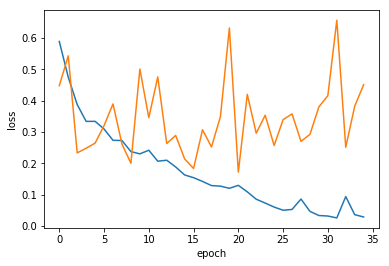

In [12]:
classifier.history.history.keys()
plt.plot(classifier.history.history['loss'])
plt.plot(classifier.history.history['val_loss'])
# plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.savefig('/Users/vwr/car autoencoder/car_autoencoder/Vanilla CNN Loss Learning Curve.jpeg')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [6]:
def compute_igs_at_epochs(data,
                          model, 
                          experiment_no,
                          experiment_dir='/Users/vwr/car autoencoder/car_autoencoder/Experiments/',
                          test_idx=[82, 104, 105, 193, 204], 
                          ig_epochs=[1, 2, 5, 10, 15, 25]):
    x_train, y_train, x_test, y_test = data
    loss = []
    val_loss = []
    for ep in range(1, 30):
        model.fit(x_train, y_train, epochs=1, batch_size=256, shuffle=True, validation_data=(x_test, y_test))
        loss.append(model.history.history['loss'][0])
        loss.append(model.history.history['val_loss'][0])
        if ep in ig_epochs:
            ig = integrated_gradients(classifier)
            for idx in test_idx:
                img = x_test[idx]
                exp = process_exp(ig.explain(img))
                exp_white = process_exp(ig.explain(img, reference=ref[0]))
                vis = img*exp
                vis_white = img*exp_white
                vis_combined = vis + vis_white
                
                img_folder = experiment_dir + str(experiment_no) + '/' + str(idx)
                save_image(img = vis,
                           img_name = 'ig_' + str(idx) + 'epoch_' + str(ep) + '_black_baseline.jpeg',
                           img_dir = img_folder)
                save_image(img = vis_white,
                           img_name = 'ig_' + str(idx) + 'epoch_' + str(ep) + '_white_baseline.jpeg',
                           img_dir = img_folder)
                save_image(img = vis_combined,
                           img_name = 'ig_' + str(idx) + 'epoch_' + str(ep) + '_combined_baseline.jpeg',
                           img_dir = img_folder + '/combined')


            
indices_not_cars = np.where(y_test!=1)[0] # cars labeled with '1'
y_test[indices_not_cars] = 0

# compute_igs_at_epochs(data = (x_train, y_train, x_test, y_test),
#                       classifier, 
#                       experiment_no = 8)




# plt.plot(loss)
# plt.plot(val_loss)
# # plt.title('model accuracy')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# # plt.savefig('/Users/vwr/car autoencoder/car_autoencoder/Experiments/7/Vanilla CNN Loss Learning Curve.jpeg')
# # plt.legend(['train', 'test'], loc='upper left')
# plt.show()
    

In [ ]:
# train on salient-blacked-out images only
classifier.fit(salient_not_cars_train_x, salient_not_cars_train_y, 
               epochs=50, batch_size=256, shuffle=True)

In [ ]:
predictions = classifier.predict(x_test)
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1
print(predictions.shape)
print(np.sum(predictions))
print(y_test.shape)

In [ ]:
classifier.save("./saved_models/824_100_epochs_fragmented_saliency_blots_very_good_separation")

In [74]:
# classifier = load_model("./best_vanilla_conv_model_val_accuracy")
# Vanilla CNN
classifier1 = load_model("./saved_models/852_100_epochs_car_classifier_from_scratch")
# classifier2 = load_model("./saved_models/761_car_classifier_first_2_frozen")

#### Integrated Gradients

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
[[ 0.99867493]]


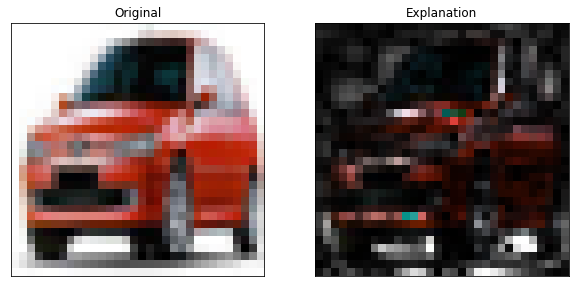

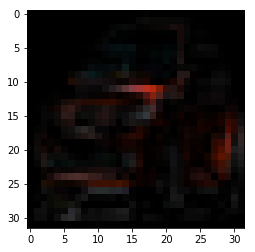

In [141]:
# 6, 37, 1020, 109, 123, 66, 81, 82, 104, 105, 114, 122, 134, 161, 193, 204, 231
# wheels!
# 6, 1020, 66, 81, 82, 105, 114, 122, 134, 161, 193, 204
# misclassified: 57, 162, 339
ig = integrated_gradients(classifier)
ig2 = integrated_gradients(classifier1)
ref = np.ones((32, 32, 3))
ref = np.expand_dims(ref, axis=0)
car_idx = 231
img = x_test[car_idx]
exp = ig.explain(img) # reference=ref[0]'
exp_white = ig.explain(img, reference=ref[0])
exp2 = ig2.explain(img, reference=ref[0])

def process_exp(exp):
    exp = gray_scale(exp)
    exp = abs(exp)
    exp = np.clip(exp/np.percentile(exp, 99.5), 0,1)  
    return exp


exp = process_exp(exp)
exp_white = process_exp(exp_white)
exp2 = process_exp(exp2)
vis = img*exp_white + img*exp
vis2 = img*exp2

print(classifier.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3)))

save_image(img = img*exp, img_name = str(car_idx) + '_black_baseline.jpeg',
                           img_dir = '/Users/vwr/car autoencoder/car_autoencoder/Experiments/8 - Saliency works (IG pics)')

save_image(img = img*exp_white, img_name = str(car_idx) + '_white_baseline.jpeg',
                           img_dir = '/Users/vwr/car autoencoder/car_autoencoder/Experiments/8 - Saliency works (IG pics)')

plot_side_by_side(img, vis, titles=["Original", "Explanation"])
plt.imshow(vis2)
plt.show()
### BLACK PIXEL experiment for IG with standard black image baseline
### USE WHITE AND BLACK BASELINES to get pixels with higher attribution (lighter and darker)

# rescaled1 = (255.0 / vis.max() * (vis - vis.min())).astype(np.uint8)
# rescaled2 = (255.0 / vis2.max() * (vis2 - vis2.min())).astype(np.uint8)
# im1 = Image.fromarray(rescaled1)
# im2 = Image.fromarray(rescaled2)
# img_name1 = 'ig_193_vanilla_cnn_8_epoch' + '.jpeg'  
# img_name2 = 'ig_193_vanilla_cnn_trained' + '.jpeg' 
# im1.save(os.path.join('/Users/vwr/car autoencoder/car_autoencoder/Experiments/3/', img_name1))
# im2.save(os.path.join('/Users/vwr/car autoencoder/car_autoencoder/Experiments/3/', img_name2))

### Generate fragmented images from most salient pixels and add to training set

In [77]:
# Vanilla CNN
# classifier = load_model("./saved_models/852_100_epochs_car_classifier_from_scratch")
cars_train_i = []
train_predictions = classifier.predict(x_train)
train_predictions[train_predictions < 0.5] = 0
train_predictions[train_predictions >= 0.5] = 1
for i in range(train_predictions.shape[0]):
    if train_predictions[i] == 1 and y_train[i] == 1:
        cars_train_i.append(i)
        
print(len(cars_train_i))
print(np.sum(train_predictions))

4112
4177.0


In [ ]:
print(classifier.predict(x_train).shape)

In [72]:
classifier = load_model("./best_vanilla_conv_model_val_accuracy")

In [ ]:
plt.imshow(x_train[486])
plt.show()

In [79]:
ig = integrated_gradients(classifier) # using vanilla CNN trained for 200 epochs
k = 0
for ind in cars_train_i:
    img = np.copy(x_train[ind])
    exp = ig.explain(img)
    exp = gray_scale(exp)
    exp = abs(exp)  
    exp = np.clip(exp/np.percentile(exp, 99.99), 0,1)
    
    threshold = np.percentile(exp, 95)
    count = 0
    for i in range(exp.shape[0]):
        for j in range(exp.shape[1]):
            if np.any(exp[i][j] > threshold, axis=0):
                count += 1
                img[i][j][0] = 0
                img[i][j][1] = 0
                img[i][j][2] = 0
    
    rescaled = (255.0 / img.max() * (img - img.min())).astype(np.uint8)
    if k % 50 == 0:
        print(classifier.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3)))
    im = Image.fromarray(rescaled)
    img_name = str(ind) + '_car.jpeg'  
    im.save(os.path.join('/Users/vwr/fragmented_saliency_cars_top_5%/', img_name))
    k += 1
#     print(classifier.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3)))

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
[[ 0.81409878]]
[[ 0.998348]]
[[ 0.87944037]]
[[ 0.30361179]]
[[ 0.17026654]]
[[ 0.52807105]]
[[ 0.93443668]]
[[ 0.94398379]]
[[ 0.93946564]]
[[ 0.38493705]]
[[ 0.6189447]]
[[ 0.12010291]]
[[ 0.01472156]]
[[ 0.94990963]]
[[ 0.91966152]]
[[ 0.40232089]]
[[ 0.54619741]]
[[ 0.83693767]]
[[ 0.59885454]]
[[ 0.90462381]]
[[ 0.53885204]]
[[ 0.99581003]]
[[ 0.96460861]]
[[ 0.84946924]]
[[ 0.67156917]]
[[ 0.25603712]]
[[ 0.59073085]]
[[ 0.87106198]]
[[ 0.76662874]]
[[ 0.98785955]]
[[ 0.15778022]]
[[ 0.99576795]]
[[ 0.94079286]]
[[ 0.97931665]]
[[ 0.08495232]]
[[ 0.76071411]]
[[ 0.83614868]]
[[ 0.73034739]]
[[ 0.93673879]]
[[ 0.82386094]]
[[ 0.90989965]]
[[ 0.14372933]]
[[ 0.69726449]]
[[ 0.58630961]]
[[ 0.7055096]]
[[ 0.55913883]]
[[ 0.96922529]]
[[ 0.09651811]]
[[ 0.97973835]]
[[ 0.82923651]]
[[ 0.97407621]]
[[ 0.58139968]]
[[ 0.39909199]]
[[ 0.52199709]]
[[ 0.38676703]]
[[ 0.95027786]]
[[ 0.504024

### Generate fragmented saliency for non-cars

In [15]:
ig = integrated_gradients(classifier) # using vanilla CNN trained for 200 epochs
k = 0
for ind in range(not_cars_x_train.shape[0]):
    img = np.copy(not_cars_x_train[ind])
    exp = ig.explain(img)
    exp = gray_scale(exp)
    exp = abs(exp)  
    exp = np.clip(exp/np.percentile(exp, 99.99), 0,1)
    
    threshold = np.percentile(exp, 95)
    count = 0
    for i in range(exp.shape[0]):
        for j in range(exp.shape[1]):
            if np.any(exp[i][j] > threshold, axis=0):
                count += 1
                img[i][j][0] = 0
                img[i][j][1] = 0
                img[i][j][2] = 0
    
    rescaled = (255.0 / img.max() * (img - img.min())).astype(np.uint8)
    if k % 50 == 0:
        print(classifier.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3)))
    im = Image.fromarray(rescaled)
    img_name = str(ind) + '_car.jpeg'  
    im.save(os.path.join('/Users/vwr/fragmented_saliency_non_cars_top_5%/', img_name))
    k += 1
#     print(classifier.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3)))

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
[[ 0.68145275]]
[[ 0.73879391]]
[[ 0.00146403]]
[[ 0.38373333]]
[[ 0.99034685]]
[[ 0.49132076]]
[[ 0.01553091]]
[[ 0.97045362]]
[[ 0.91572422]]
[[ 0.85539645]]
[[ 0.17884463]]
[[ 0.94366604]]
[[ 0.75715172]]
[[ 0.84017628]]
[[ 0.56193942]]
[[ 0.23408557]]
[[ 0.90728486]]
[[ 0.20637766]]
[[ 0.24835031]]
[[ 0.80201548]]
[[ 0.01659775]]
[[ 0.98315698]]
[[ 0.23622471]]
[[ 0.06677269]]
[[ 0.24084057]]
[[ 0.90947378]]
[[ 0.77435207]]
[[ 0.90130287]]
[[ 0.25446165]]
[[ 0.21045643]]
[[ 0.68271679]]
[[ 0.21215783]]
[[ 0.79594058]]
[[ 0.94575238]]
[[ 0.02614246]]
[[ 0.99496633]]
[[ 0.11482271]]
[[ 0.08944497]]
[[ 0.4258]]
[[ 0.6975345]]
[[ 0.99130803]]
[[ 0.15815166]]
[[ 0.87683523]]
[[ 0.03965757]]
[[ 0.13686436]]
[[ 0.27353522]]
[[ 0.48967108]]
[[ 0.4350138]]
[[ 0.65586066]]
[[ 0.94461155]]
[[ 0.53883547]]
[[ 0.95872587]]
[[ 0.72292757]]
[[ 0.5751223]]
[[ 0.9077574]]
[[ 0.4829964]]
[[ 0.88916808]]


In [ ]:
predictions = classifier2.predict(x_test)
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1
print(np.sum(predictions))
print(predictions.shape)

### Visualizing Conv Filters

In [ ]:
l2 = classifier.layers[2]
l3 = classifier.layers[3]
l4 = classifier.layers[4]
l5 = classifier.layers[5]
l6 = classifier.layers[6]
l7 = classifier.layers[7]
l8 = classifier.layers[8]
l9 = classifier.layers[9]
l10 = classifier.layers[10]
l12 = classifier.layers[12]
l14 = classifier.layers[14]

x = l2(classifier.input)
x = l3(x)
x = l4(x)
x = l5(x)
x = l6(x)
x = l7(x)
x = l8(x)
x = l9(x)
x = l10(x)
x = l12(x)
output = l14(x)

classifier = Model(classifier.input, output)

In [ ]:
# Visualizing Conv Filters
from keras import backend as K

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
#     x = x.transpose((0, 1, 2))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

layer_dict = dict([(layer.name, layer) for layer in classifier.layers])
layer_index = 7
input_img = classifier.input

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = classifier.layers[layer_index].get_output_at(1)
    
    loss = K.mean(layer_output[:, :, :, i])
    
    # compute the gradient of the loss wrt the input picture
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    
    # we start from a gray image with some noise
    input_img_data = (np.random.random((1, IMG_SIZE, IMG_SIZE, 3)) - 0.5) * 20 + 128
#     input_img_data = np.copy(x_test[82]).reshape(1, IMG_SIZE, IMG_SIZE, 3)

    # run gradient ascent for 20 steps
    for j in range(5):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * 0.1
        input_img_data = 0.95 * input_img_data
        input_img_data = cv2.GaussianBlur(input_img_data[0, :], (1, 1), 0)
        input_img_data = input_img_data.reshape(1, 32, 32, 3)
    
    img = input_img_data[0]
    img = deprocess_image(img)
    fig.add_subplot(rows, columns, i)   
    plt.imshow(img)
plt.show()

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in classifier.layers])
layer_index = 7
input_img = classifier.input

layer_output = classifier.layers[layer_index].get_output_at(1)
mean_activation_i = K.mean(layer_output[:, :, :, 36])
iterate = K.function([input_img], [mean_activation_i])

(cars_x_train, _, _, _) = select_car_images()
mean_values = []
for car in cars_x_train:
    mean_activ_value = iterate([car.reshape(1, IMG_SIZE, IMG_SIZE, 3)])
    mean_values.append(mean_activ_value)

In [ ]:
mean_values = np.array(mean_values)
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

# 12 is diagonal right
boom = largest_indices(mean_values, 5)
print(mean_values[boom])
print(boom)
plt.imshow(x_test[1193])
plt.show()

### Test Set Breakdown + misclassifications

In [106]:
predictions = classifier.predict(x_test)
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

category_of = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
table = { 'plane': 0,'car': 0, 'bird': 0, 'cat': 0, 'deer': 0, 'dog': 0, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0}
total_counts = { 'plane': 0,'car': 0, 'bird': 0, 'cat': 0, 'deer': 0, 'dog': 0, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0}

misclassified_as_cars = []
cars_i = []
cars_misclassified_as_not = []

for i in range(predictions.shape[0]):
    c = category_of[y_test[i][0]]
    total_counts[c] += 1
    if predictions[i] == 1:
        if c != 'car':
            misclassified_as_cars.append(i)
        else:
            cars_i.append(i)
        table[c] += 1
    if predictions[i] != 1 and c == 'car':
            cars_misclassified_as_not.append(i)
        
print("What this classifier classifies as cars: \n", table)
print("Total population of test set: \n", total_counts)

What this classifier classifies as cars: 
 {'plane': 62, 'car': 879, 'bird': 16, 'cat': 19, 'deer': 12, 'dog': 6, 'frog': 19, 'horse': 10, 'ship': 159, 'truck': 299}
Total population of test set: 
 {'plane': 1000, 'car': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


In [44]:
train_predictions = classifier.predict(salient_not_cars_train_x)
train_predictions[train_predictions < 0.5] = 0
train_predictions[train_predictions >= 0.5] = 1
print(np.sum(train_predictions))
print(len(np.where(train_predictions == 1)[0]))
print(len(np.where(salient_not_cars_train_y == 1)[0]))
print(train_predictions.shape)

4498.0
4498
4112
(8612, 1)


After epoch 1:  
{'plane': 396, 'car': 886, 'bird': 169, 'cat': 250, 'deer': 138, 'dog': 186, 'frog': 176, 'horse': 176, 'ship': 580, 'truck': 807}    
After epoch 2:  
{'plane': 63, 'car': 673, 'bird': 36, 'cat': 29, 'deer': 11, 'dog': 12, 'frog': 13, 'horse': 16, 'ship': 146, 'truck': 349}   
After epoch 3:   
{'plane': 41, 'car': 594, 'bird': 12, 'cat': 6, 'deer': 5, 'dog': 4, 'frog': 2, 'horse': 4, 'ship': 82, 'truck': 293}   
After epoch 5:  
{'plane': 90, 'car': 828, 'bird': 43, 'cat': 26, 'deer': 15, 'dog': 21, 'frog': 18, 'horse': 30, 'ship': 165, 'truck': 491}    
After epoch 10:  
{'plane': 72, 'car': 807, 'bird': 20, 'cat': 18, 'deer': 15, 'dog': 9, 'frog': 13, 'horse': 12, 'ship': 111, 'truck': 363}  
After epoch 15:  
 {'plane': 66, 'car': 821, 'bird': 21, 'cat': 32, 'deer': 16, 'dog': 12, 'frog': 24, 'horse': 14, 'ship': 90, 'truck': 331}  
After epoch 21:  
{'plane': 82, 'car': 862, 'bird': 24, 'cat': 37, 'deer': 17, 'dog': 12, 'frog': 29, 'horse': 11, 'ship': 162, 'truck': 472}  
After epoch 26:  
{'plane': 85, 'car': 900, 'bird': 34, 'cat': 45, 'deer': 22, 'dog': 13, 'frog': 29, 'horse': 36, 'ship': 164, 'truck': 468}





After 1 epoch of dta augmentation of original + black car images + black not cars:  
{'plane': 165, 'car': 789, 'bird': 83, 'cat': 182, 'deer': 113, 'dog': 89, 'frog': 135, 'horse': 161, 'ship': 270, 'truck': 628}   
After 2 epochs:   
{'plane': 138, 'car': 783, 'bird': 41, 'cat': 63, 'deer': 34, 'dog': 39, 'frog': 42, 'horse': 52, 'ship': 244, 'truck': 578}  
After 3 epochs:  
{'plane': 60, 'car': 560, 'bird': 13, 'cat': 16, 'deer': 10, 'dog': 6, 'frog': 5, 'horse': 12, 'ship': 78, 'truck': 241}  
After 4 epochs:   
{'plane': 48, 'car': 710, 'bird': 14, 'cat': 12, 'deer': 9, 'dog': 4, 'frog': 7, 'horse': 11, 'ship': 111, 'truck': 293}  
After 5 epochs:  
{'plane': 97, 'car': 840, 'bird': 13, 'cat': 20, 'deer': 18, 'dog': 9, 'frog': 22, 'horse': 28, 'ship': 191, 'truck': 461}  
After 6 epochs:   
{'plane': 42, 'car': 761, 'bird': 9, 'cat': 10, 'deer': 5, 'dog': 1, 'frog': 5, 'horse': 9, 'ship': 113, 'truck': 311}  
After 8 epochs:  
{'plane': 40, 'car': 784, 'bird': 9, 'cat': 10, 'deer': 4, 'dog': 2, 'frog': 9, 'horse': 3, 'ship': 129, 'truck': 315}  
After 10 epochs:  
{'plane': 32, 'car': 787, 'bird': 9, 'cat': 13, 'deer': 12, 'dog': 3, 'frog': 13, 'horse': 12, 'ship': 88, 'truck': 248}  
After 12 epochs:  
{'plane': 52, 'car': 887, 'bird': 17, 'cat': 14, 'deer': 11, 'dog': 7, 'frog': 18, 'horse': 11, 'ship': 159, 'truck': 394}  
After 15 epochs:  
 {'plane': 51, 'car': 856, 'bird': 16, 'cat': 15, 'deer': 13, 'dog': 4, 'frog': 15, 'horse': 10, 'ship': 118, 'truck': 282}  
After 17 epochs:   
{'plane': 95, 'car': 887, 'bird': 28, 'cat': 22, 'deer': 13, 'dog': 12, 'frog': 28, 'horse': 24, 'ship': 167, 'truck': 349}  
After 19 epochs:  
{'plane': 62, 'car': 879, 'bird': 16, 'cat': 19, 'deer': 12, 'dog': 6, 'frog': 19, 'horse': 10, 'ship': 159, 'truck': 299}

In [107]:
classifier.save("saliency works! 879_epochs_19_car_conv")

In [ ]:
result = classifier.predict(x_test[953].reshape(1, IMG_SIZE, IMG_SIZE, 3))
print(result)

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
# 90
for i in range(1, columns*rows +1):
    img = x_test[cars_misclassified_as_not[i]]
    print(cars_misclassified_as_not[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()